In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


In [2]:
import os
import subprocess
import inspect

import math
import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh
import pickle as pkl

from src.depth import DepthPoset

import itertools

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import lines as mlines
from matplotlib.patches import Patch

from src.depth import DepthPoset
from src import depth_poset_similarity_scores

from tqdm import tqdm
from src.profiling import Timer

# Load and Format the Data

## Define Directories

In [3]:
# the directory to save pictures
path_to_save = 'raports/pics/torus-transpositions-extended'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

In [4]:
# the directory to load transpositions data
directory = "results/transpositions-during-linear-homotopy-between-extended-barycentric-cubical-toruses"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

## Check sizes of files

In [5]:
def get_dim_and_n_from_torus_file(path):
    with open(path, 'rb') as file:
        res = pkl.load(file)
    return res['dim'], res['n']

/tmp/ipykernel_199607/3943854577.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses-extended/{path}.pkl')
Extracting the Dimensions and sizes of toruses: 100%|██████████| 495/495 [00:00<00:00, 651.65it/s]


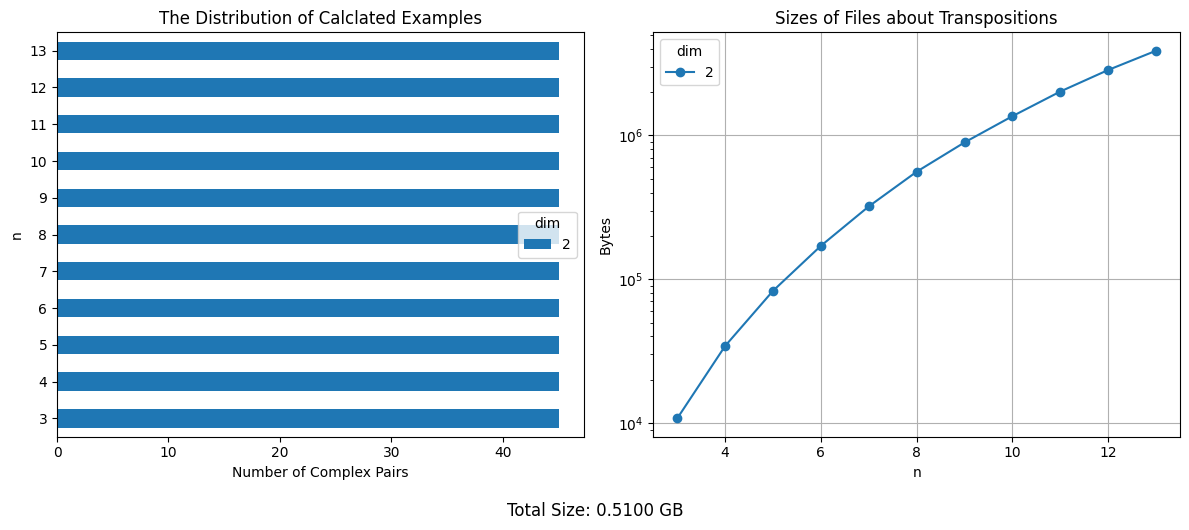

In [6]:
df_sizes = pd.DataFrame({'path': paths})
df_sizes['size'] = df_sizes['path'].apply(lambda path: os.path.getsize(path))
df_sizes['original_path0'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[0])
df_sizes['original_path1'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[1])
df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses-extended/{path}.pkl')
df_sizes['original_size0'] = df_sizes['original_path0'].apply(lambda path: os.path.getsize(path))
df_sizes['original_size1'] = df_sizes['original_path1'].apply(lambda path: os.path.getsize(path))
tqdm.pandas(desc='Extracting the Dimensions and sizes of toruses')
df_sizes['dim&n'] = df_sizes['original_path0'].progress_apply(lambda path: get_dim_and_n_from_torus_file(path))
df_sizes['dim'] = df_sizes['dim&n'].apply(lambda dimn: dimn[0])
df_sizes['n'] = df_sizes['dim&n'].apply(lambda dimn: dimn[1])
df_sizes = df_sizes.drop(columns='dim&n')


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_title('The Distribution of Calclated Examples')
df_sizes.groupby(['dim', 'n'])['path'].count().reset_index().pivot_table(columns='dim', index='n', values='path').fillna(0).astype(int).plot(kind='barh', ax=axs[0])
axs[0].set_xlabel('Number of Complex Pairs')

axs[1].set_title('Sizes of Files about Transpositions')
df_sizes.groupby(['dim', 'n'])['size'].mean().reset_index().pivot_table(columns='dim', index='n', values='size').plot(logy=True, marker='o', ax=axs[1])
axs[1].set_ylabel('Bytes')
axs[1].grid(True)

fig.text(0.5, -0.05, f"Total Size: {df_sizes['size'].sum()*1024**-3:.4f} GB", ha='center', va='bottom', fontsize='large')
plt.tight_layout()
plt.show()

## Load Transpositions Data

In [7]:
df = []
errs = {}
for path in tqdm(paths):
    if os.path.getsize(path) < np.inf*1024**2:
        try:
            with open(path, 'rb') as file:
                loaded_dict = pkl.load(file)
            loaded_dict['transpositions'].insert(0, 'complex_index0', loaded_dict['complex_index0'])
            loaded_dict['transpositions'].insert(1, 'complex_index1', loaded_dict['complex_index1'])
            loaded_dict['transpositions'].insert(2, 'complex_dim', loaded_dict['complex_dim'])
            loaded_dict['transpositions'].insert(3, 'complex_shape', [loaded_dict['complex_shape']]*len(loaded_dict['transpositions']))
            df.append(loaded_dict['transpositions'])

        except Exception as err:
            errs.update({path: err})
    else:
        errs.update({path: 'Giant file'})
errs = pd.Series(errs)
if len(errs) > 0:
    errs_count = errs.astype(str).value_counts()
    print(f'There is some amount of errors:\n{errs_count.to_string(name=False)}\n')
    #for path in errs.index:
    #    if os.path.exists(path):
    #        os.remove(path)
    
df = pd.concat(df)

if not 'complex_n' in df.columns: 
    df.insert(3, 'complex_n', df['complex_shape'].apply(lambda x: x[0] if (np.array(x)[1:] == np.array(x)[:-1]).all() else None))

#print(f'There are {pd.isna(df['transposition']).sum()} empty transposition values in {len(df)} lines')
#df = df[~pd.isna(df['transposition'])]
#df = df.join(df['transposition'].apply(lambda tr: tr.to_dict()).apply(pd.Series))

print(f'df.shape = {df.shape}')
df.head()

100%|██████████| 495/495 [00:03<00:00, 139.73it/s]


df.shape = (5981095, 18)


,complex_index0,complex_index1,complex_dim,complex_n,complex_shape,time,value,index 0,index 1,cell 0,cell 1,dim,type,switch,birth_relation_cell_similarity,death_relation_cell_similarity,poset_closure_arcs_cell_similarity,poset_reduction_arcs_cell_similarity
0,2025-07-15 15:04:07.297023,2025-07-15 15:04:07.336225,2,3,"(3, 3)",0.005997,2.975740,34,35,"((2, 2), (2, 0), (0, 2), (0, 0))","((2, 1), (2, 2), (0, 1), (0, 2))",2,death-death,no switch,0.950000,1.0,0.976190,0.888889
1,2025-07-15 15:04:07.297023,2025-07-15 15:04:07.336225,2,3,"(3, 3)",0.020968,1.707239,24,25,"((1, 2), (2, 2))","((0, 0), (0, 1))",1,birth-birth,no switch,1.000000,1.0,1.000000,1.000000
2,2025-07-15 15:04:07.297023,2025-07-15 15:04:07.336225,2,3,"(3, 3)",0.044589,1.692716,23,24,"((1, 1), (1, 2))","((0, 0), (0, 1))",1,birth-birth,no switch,1.000000,1.0,1.000000,1.000000
3,2025-07-15 15:04:07.297023,2025-07-15 15:04:07.336225,2,3,"(3, 3)",0.044775,1.394897,15,16,"((0, 2), (1, 2))","((2, 0), (0, 0))",1,death-death,no switch,0.952381,1.0,0.976744,0.888889
4,2025-07-15 15:04:07.297023,2025-07-15 15:04:07.336225,2,3,"(3, 3)",0.075816,1.492439,18,19,"((2, 2), (2, 0))","((2, 0), (2, 1))",1,birth-birth,no switch,1.000000,1.0,1.000000,1.000000


In [8]:
def cmap_cud(i):
    cud_colors = np.array(["#000000", "#E69F00", "#56B4E9", "#009E73", 
                           "#F0E442", "#0072B2", "#D55E00", "#CC79A7",])
    return cud_colors[i]

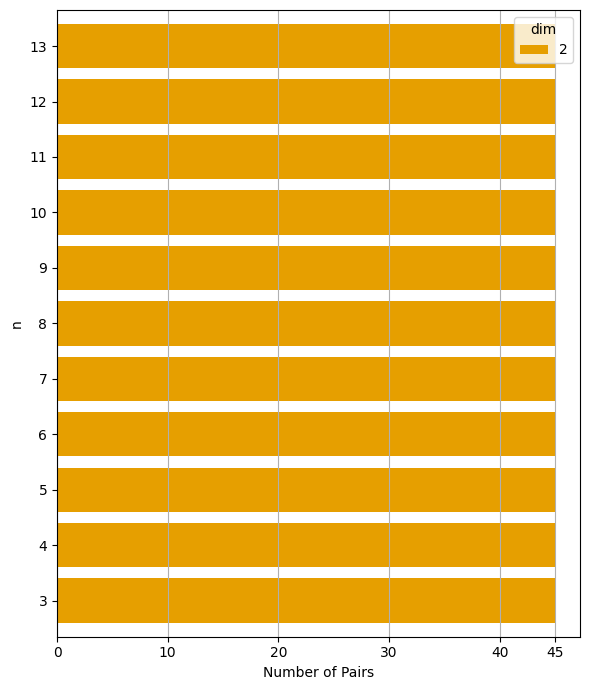

In [9]:
fig, ax = plt.subplots(figsize=(6, 7))

cmap_categorical = plt.get_cmap('Dark2')
cmap_categorical = plt.get_cmap('Accent')
cmap_categorical = cmap_cud
colors = cmap_categorical([1]) # I just seted color here to compare with scores. This will be broken, if we'll add other dimensions

df_to_plot = df.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n'])['index 0'].count().reset_index().groupby(['complex_dim', 'complex_n']
            )['complex_index0'].count().reset_index().rename(columns=lambda s: s.replace('complex_', '')).pivot_table(columns='dim', index='n', values='index0').fillna(0).astype(int)
df_to_plot.plot(kind='barh', color=colors, width=0.8, ax=ax)

ax.set_xlabel('Number of Pairs')

xticks = ax.get_xticks()
xticks = np.unique(np.append(xticks[xticks <= df_to_plot.max().max()], df_to_plot.max().max())).astype(int)

ax.set_xticks(xticks)

ax.grid(axis='x')

plt.tight_layout()

plt.savefig(os.path.join(path_to_save, 'distribution.png'))

# Switch Types Distribution

In [10]:
tqdm.pandas(desc="Define switch type from type and switch columns")
df['switch type'] = df.progress_apply(lambda row: row['type'] if row['switch'] in ['switch', 'switch backward', 'switch forward'] else row['switch'], axis=1)

df['switch type'].value_counts()

Define switch type from type and switch columns: 100%|██████████| 5981095/5981095 [00:36<00:00, 162394.46it/s]


switch type
no switch      5857983
birth-birth      50983
death-death      46043
birth-death      26086
Name: count, dtype: int64

In [11]:
# define colors and markers
switch_type_colors = pd.Series({
    'no switch': '#000000',    # black
    'birth-birth': '#0072B2',  # blue (CUD-safe)
    'birth-death': '#E69F00',  # orange (CUD-safe)
    'death-death': '#CC79A7',  # purple/pinkish (CUD-safe)
}, name='color')
switch_type_markers = pd.Series({
    'no switch': 'o',
    'birth-birth': '^',
    'birth-death': 'X',
    'death-death': 'v',
}, name='marker')

pd.DataFrame([switch_type_colors, switch_type_markers])

,no switch,birth-birth,birth-death,death-death
color,#000000,#0072B2,#E69F00,#CC79A7
marker,o,^,X,v


In [12]:
df_switch_types = df.copy()

with Timer() as timer:
    df_switch_types = df_switch_types.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n', 'dim', 'switch type'])['index 0'].count().reset_index().rename(columns={'index 0': 'count'})
    print(f'Calculated counts-values for each type in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()
    
    df_switch_types_mean = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].mean().reset_index()
    df_switch_types_mean = df_switch_types_mean.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')
    df_switch_types_mean.index.name = 'n'
    print(f'Calculated mean count in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()
    

    df_switch_types_std = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].std().reset_index()
    df_switch_types_std = df_switch_types_std.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')
    df_switch_types_std.index.name = 'n'
    print(f'Calculated variation count in {timer.elapsed():.4f} seconds.')

df_switch_types_mean = df_switch_types_mean.sort_index(axis=1)
df_switch_types_std = df_switch_types_std.sort_index(axis=1)

complex_dims = pd.unique(df['complex_dim'])
transposition_dims = pd.unique(df['dim'])

print()
print(f'df_switch_types_std.shape = {df_switch_types_std.shape}')
print('...\n')
print(f'df_switch_types_mean.shape = {df_switch_types_mean.shape}')
df_switch_types_mean.head()


Calculated counts-values for each type in 1.2558 seconds.
Calculated mean count in 0.0061 seconds.
Calculated variation count in 0.0128 seconds.

df_switch_types_std.shape = (11, 10)
...

df_switch_types_mean.shape = (11, 10)


complex_dim           2                                                  \
dim                   0                                   1               
switch type birth-birth birth-death   no switch birth-birth birth-death   
n                                                                         
3              2.634146    1.222222   13.688889    8.333333    5.088889   
4              5.069767    2.250000   49.422222   14.577778   10.044444   
5              9.177778    2.318182  144.266667   24.822222   15.688889   
6             14.177778    2.704545  291.133333   34.066667   22.511111   
7             20.022222    2.266667  550.155556   45.155556   31.355556   

complex_dim                                                               
dim                                            2                          
switch type death-death    no switch birth-death death-death   no switch  
n                                                                         
3              3.933333    59.000000    1.952381    2.785714   13.844444  
4              9.088889   220.488889    1.860465    5.022222   53.266667  
5             17.000000   545.555556    2.000000    9.488889  138.888889  
6             26.400000  1175.711111    2.720930   13.622222  289.488889  
7             39.200000  2226.511111    2.363636   19.711111  580.000000

In [13]:
pictypes_filename_template = 'transposition-types-complex-dim{complex_dim}-subposet-dim{dim}-drop-no-switches-{drop_no_switch}.png'

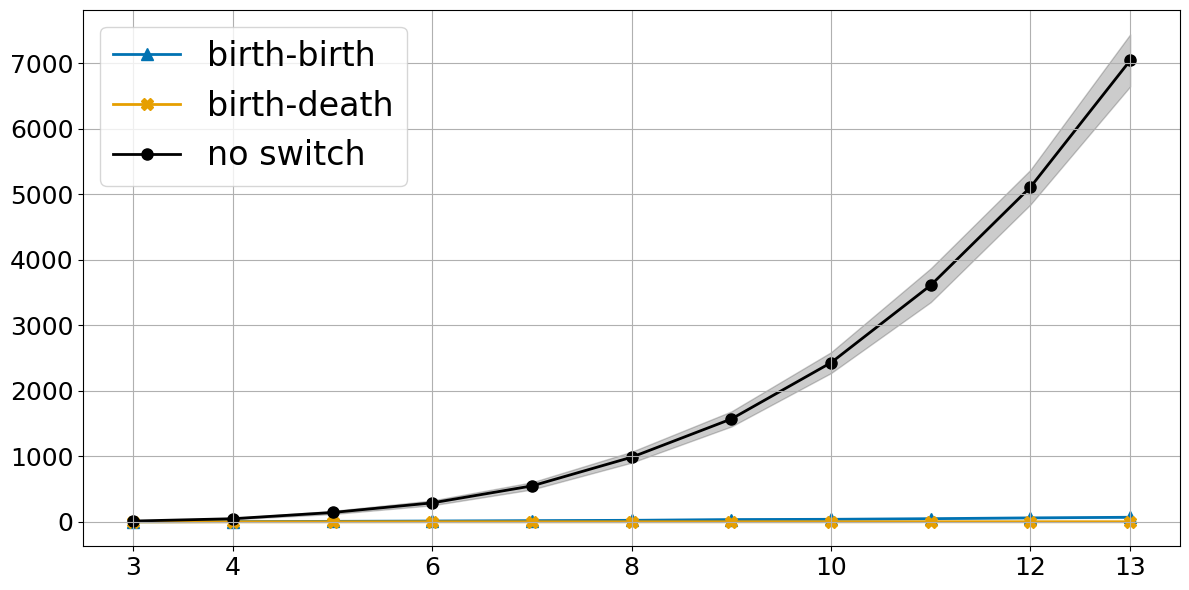

In [14]:
show = True
for irow, row in df_switch_types_mean.columns.to_frame()[['complex_dim', 'dim']].drop_duplicates().reset_index(drop=True).iterrows():
    complex_dim, dim = row
    for drop_no_switch in np.arange(2).astype(bool):
        row['drop_no_switch'] = drop_no_switch
        path = os.path.join(path_to_save, pictypes_filename_template.format(**row))
        df_this_mean = df_switch_types_mean[complex_dim][dim]
        df_this_std = df_switch_types_std[complex_dim][dim]

        if drop_no_switch:
            df_this_mean = df_this_mean.drop(columns='no switch')
            df_this_std = df_this_std.drop(columns='no switch')

        assert df_this_mean.columns.to_list() == df_this_std.columns.to_list()
        assert df_this_mean.index.to_list() == df_this_std.index.to_list()

        fig, ax = plt.subplots(figsize=(12, 6))
        
        for col in df_this_mean.columns:
            x = df_this_mean.index.values
            y_mean = df_this_mean[col].values
            y_std = df_this_std[col].values

            ax.plot(x, y_mean, color=switch_type_colors[col], marker=switch_type_markers[col], label=col, linewidth=2, markersize=8, zorder=1)
            ax.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2, color=switch_type_colors[col], zorder=0)

        xticks = ax.get_xticks().astype(int)
        xticks = np.concatenate([xticks[(xticks > x.min())&(xticks < x.max())], [x.min(), x.max()]]).astype(int)
        xticks = np.unique(xticks)
        ax.set_xticks(xticks)
        ax.set_xticklabels(ax.get_xticks(), fontsize=18)
        , fontsize=24
        yticks = ax.get_yticks()
        if (yticks.astype(int) == yticks).all():
            yticks = yticks.astype(int)
        y_max = (df_this_mean + df_this_std).max().max()
        y_min = (df_this_mean - df_this_std).min().min()
        while (y_max < 0.5*(yticks[-1] + yticks[-2])) and (len(yticks) > 3):
            yticks = yticks[:-1]
        while (y_min > 0.5*(yticks[0] + yticks[1])) and (len(yticks) > 3):
            yticks = yticks[1:]
        yticks = np.round(yticks, 2)
        yticks = yticks[yticks >= 0]
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks, fontsize=18) 

        ax.grid(True)
        ax.legend(fontsize=24)
        #ax.set_xlabel('$n$')
        plt.tight_layout()
        plt.savefig(path)
        if show:
            plt.show()
            show = False
        plt.close()

In [15]:
figure_2_layers_template = r"""
\begin{{figure}}[htbp]
\centering
{level0}
\vspace{{0.5cm}}
{level1}
\caption{{{caption}}}
\label{{{label}}}
\end{{figure}}
""".strip()

subfigure_template = r"""
\begin{{subfigure}}[b]{{{figwidth}\textwidth}}
    \includegraphics[width=\linewidth]{{{path}}}
    \caption{{{caption}}}
    \label{{{label}}}
\end{{subfigure}}
""".strip()


In [16]:
typedistribution_prefix_template = """
\\par The distribution of transpositions types for the model $\\mathbb{{T}}^{{{complex_dim}}}_n$ we can see in the figure Fig. \\ref{{{label}}}.
"""

In [17]:
switch_type_distributions_ltx = []

for complex_dim in pd.unique(df_switch_types['complex_dim']):
    

    figwidth = round(0.90/(complex_dim + 1), 2)

    subfigures_level0 = []
    subfigures_level1 = []
    
    for dim in range(complex_dim + 1):
        path = os.path.join(path_to_save, pictypes_filename_template.format(complex_dim=complex_dim, dim=dim, drop_no_switch=False))
        path = path.replace('raports/', '')
        caption = f"Cells dimension {dim}"
        label = f'fig:complex{complex_dim}cells{dim}'
        subfigures_level0.append(subfigure_template.format(figwidth=figwidth, path=path, caption=caption, label=label))

        path = os.path.join(path_to_save, pictypes_filename_template.format(complex_dim=complex_dim, dim=dim, drop_no_switch=True))
        path = path.replace('raports/', '')
        caption = f"Cells dimension {dim} (without no switch transpositions)"
        label = f'fig:complex{complex_dim}cells{dim}onlyswitch'
        subfigures_level1.append(subfigure_template.format(figwidth=figwidth, path=path, caption=caption, label=label))
    
    level0 = '\n\\hfill\n'.join(subfigures_level0)
    level1 = '\n\\hfill\n'.join(subfigures_level1)
    caption = f'The switch type distribution for $\\mathbb{{T}}_n^{{{complex_dim}}}$'
    label = 'fig:' + f'typesdistribution{complex_dim}'
    
    text0 = typedistribution_prefix_template.format(complex_dim=complex_dim, label=label)
    text1 = figure_2_layers_template.format(level0=level0, level1=level1, caption=caption, label=label)
    switch_type_distributions_ltx.append(text0 + text1)

switch_type_distributions_ltx = '\n\n'.join(switch_type_distributions_ltx)
print(switch_type_distributions_ltx)


\par The distribution of transpositions types for the model $\mathbb{T}^{2}_n$ we can see in the figure Fig. \ref{fig:typesdistribution2}.
\begin{figure}[htbp]
\centering
\begin{subfigure}[b]{0.3\textwidth}
    \includegraphics[width=\linewidth]{pics/torus-transpositions-extended/transposition-types-complex-dim2-subposet-dim0-drop-no-switches-False.png}
    \caption{Cells dimension 0}
    \label{fig:complex2cells0}
\end{subfigure}
\hfill
\begin{subfigure}[b]{0.3\textwidth}
    \includegraphics[width=\linewidth]{pics/torus-transpositions-extended/transposition-types-complex-dim2-subposet-dim1-drop-no-switches-False.png}
    \caption{Cells dimension 1}
    \label{fig:complex2cells1}
\end{subfigure}
\hfill
\begin{subfigure}[b]{0.3\textwidth}
    \includegraphics[width=\linewidth]{pics/torus-transpositions-extended/transposition-types-complex-dim2-subposet-dim2-drop-no-switches-False.png}
    \caption{Cells dimension 2}
    \label{fig:complex2cells2}
\end{subfigure}
\vspace{0.5cm}
\begin{

# Similarity Scores

In [18]:
scores = df.columns.values
scores = scores[np.isin(scores, [name for name, f in inspect.getmembers(depth_poset_similarity_scores, inspect.isfunction)])]
scores = scores.tolist()
scores

['birth_relation_cell_similarity',
 'death_relation_cell_similarity',
 'poset_closure_arcs_cell_similarity',
 'poset_reduction_arcs_cell_similarity']

In [19]:
def get_score_title(score):
    # 
    try:
        return {
            'birth_relation_cell_similarity': 'Jacard Similarity for Birth Cells', 
            'death_relation_cell_similarity': 'Jacard Similarity for Death Cells', 
            #'poset_closure_arcs_cell_similarity': 'Jacard Similarity for Edges in the Poset Closure Graph',
            #'poset_reduction_arcs_cell_similarity': 'Jacard Similarity for Edges in the Poset Reduction Graph', 
            'poset_closure_arcs_cell_similarity': 'Jacard Similarity for Edges in the Transitive Closure',
            'poset_reduction_arcs_cell_similarity': 'Jacard Similarity for Edges in the Transitive Reduction', 
        }[score]
    except KeyError:
        return score

score_titles = pd.Series({score: get_score_title(score) for score in scores})
score_titles

birth_relation_cell_similarity                          Jacard Similarity for Birth Cells
death_relation_cell_similarity                          Jacard Similarity for Death Cells
poset_closure_arcs_cell_similarity      Jacard Similarity for Edges in the Transitive ...
poset_reduction_arcs_cell_similarity    Jacard Similarity for Edges in the Transitive ...
dtype: object

In [20]:
df[['complex_dim', 'complex_n'] + scores].groupby(['complex_dim', 'complex_n']).count()

birth_relation_cell_similarity  \
complex_dim complex_n                                   
2           3                                    5026   
            4                                   16674   
            5                                   40910   
            6                                   84256   
            7                                  158251   
            8                                  275389   
            9                                  439819   
            10                                 668650   
            11                                 991215   
            12                                1398583   
            13                                1902322   

                       death_relation_cell_similarity  \
complex_dim complex_n                                   
2           3                                    5026   
            4                                   16674   
            5                                   40910   
            6                                   84256   
            7                                  158251   
            8                                  275389   
            9                                  439819   
            10                                 668650   
            11                                 991215   
            12                                1398583   
            13                                1902322   

                       poset_closure_arcs_cell_similarity  \
complex_dim complex_n                                       
2           3                                        5026   
            4                                       16674   
            5                                       40910   
            6                                       84256   
            7                                      158251   
            8                                      275389   
            9                                      439819   
            10                                     668650   
            11                                     991215   
            12                                    1398583   
            13                                    1902322   

                       poset_reduction_arcs_cell_similarity  
complex_dim complex_n                                        
2           3                                          5026  
            4                                         16674  
            5                                         40910  
            6                                         84256  
            7                                        158251  
            8                                        275389  
            9                                        439819  
            10                                       668650  
            11                                       991215  
            12                                      1398583  
            13                                      1902322

In [21]:
df_scores_mean = df[['complex_dim', 'complex_n', 'dim', 'switch type'] + scores].groupby(['complex_dim', 'complex_n', 'dim', 'switch type']).mean()
df_scores_std = df[['complex_dim', 'complex_n', 'dim', 'switch type'] + scores].groupby(['complex_dim', 'complex_n', 'dim', 'switch type']).std()

def regroup_df(df):
    df = df.reset_index(drop=False)
    df = df.melt(id_vars=['complex_dim', 'complex_n', 'dim', 'switch type'], value_vars=scores, var_name='score', value_name='value')
    df = df.pivot_table(index='complex_n', columns=['score', 'complex_dim', 'dim', 'switch type'], values='value')
    return df

df_scores_mean = regroup_df(df_scores_mean)
df_scores_std = regroup_df(df_scores_std)

print(f'df_scores_mean.shape = {df_scores_mean.shape}')
print(f'df_scores_std.shape = {df_scores_std.shape}')

assert (df_scores_mean.columns == df_scores_std.columns).all()
assert (df_scores_mean.index == df_scores_std.index).all()

nrows = min(5, len(df_scores_mean))
pd.concat([df_scores_mean.head(nrows), df_scores_std.head(nrows)])

df_scores_mean.shape = (11, 40)
df_scores_std.shape = (11, 40)


score       birth_relation_cell_similarity                                    \
complex_dim                              2                                     
dim                                      0                                 1   
switch type                    birth-birth birth-death no switch birth-birth   
complex_n                                                                      
3                                 0.687901    0.787225       1.0    0.512950   
4                                 0.785698    0.845227       1.0    0.651831   
5                                 0.832331    0.877027       1.0    0.757027   
6                                 0.860037    0.877811       1.0    0.823986   
7                                 0.894731    0.890173       1.0    0.855070   
3                                 0.112861    0.077755       0.0    0.122950   
4                                 0.109386    0.083970       0.0    0.114169   
5                                 0.085794    0.055418       0.0    0.089055   
6                                 0.081029    0.064248       0.0    0.076676   
7                                 0.070557    0.053427       0.0    0.070709   

score                                                                  \
complex_dim                                                             
dim                                                     2               
switch type birth-death death-death no switch birth-death death-death   
complex_n                                                               
3              0.594658    0.757973  0.992995    0.743422    0.548589   
4              0.713978    0.811019  0.996923    0.810621    0.694802   
5              0.781100    0.841649  0.998493    0.838134    0.795074   
6              0.842465    0.879170  0.999071    0.869087    0.844676   
7              0.872783    0.905085  0.999472    0.912646    0.877515   
3              0.144103    0.131340  0.024261    0.139475    0.146555   
4              0.132447    0.105133  0.012745    0.086660    0.105031   
5              0.110448    0.088717  0.007153    0.065089    0.086565   
6              0.094708    0.073551  0.004911    0.057826    0.070896   
7              0.077096    0.058757  0.003172    0.041090    0.066303   

score                  ... poset_reduction_arcs_cell_similarity              \
complex_dim            ...                                    2               
dim                    ...                                    0               
switch type no switch  ...                          birth-birth birth-death   
complex_n              ...                                                    
3            0.965031  ...                             0.670694    0.782260   
4            0.989790  ...                             0.780949    0.846487   
5            0.996063  ...                             0.831126    0.883919   
6            0.998015  ...                             0.870111    0.905518   
7            0.998833  ...                             0.900501    0.916602   
3            0.063171  ...                             0.095180    0.070828   
4            0.026596  ...                             0.090151    0.065554   
5            0.013451  ...                             0.069221    0.047642   
6            0.007839  ...                             0.061259    0.038490   
7            0.005310  ...                             0.054491    0.035983   

score                                                                \
complex_dim                                                           
dim                             1                                     
switch type no switch birth-birth birth-death death-death no switch   
complex_n                                                             
3            0.976696    0.576925    0.600101    0.686544  0.975826   
4            0.992118    0.711992    0.735038    0.780050  0.990594   
5            0.99613

In [22]:
picscores_filename_template = 'score-{score}-complex-dim{complex_dim}-transpositions-dim{dim}.png'

100%|██████████| 12/12 [00:01<00:00,  6.97it/s]


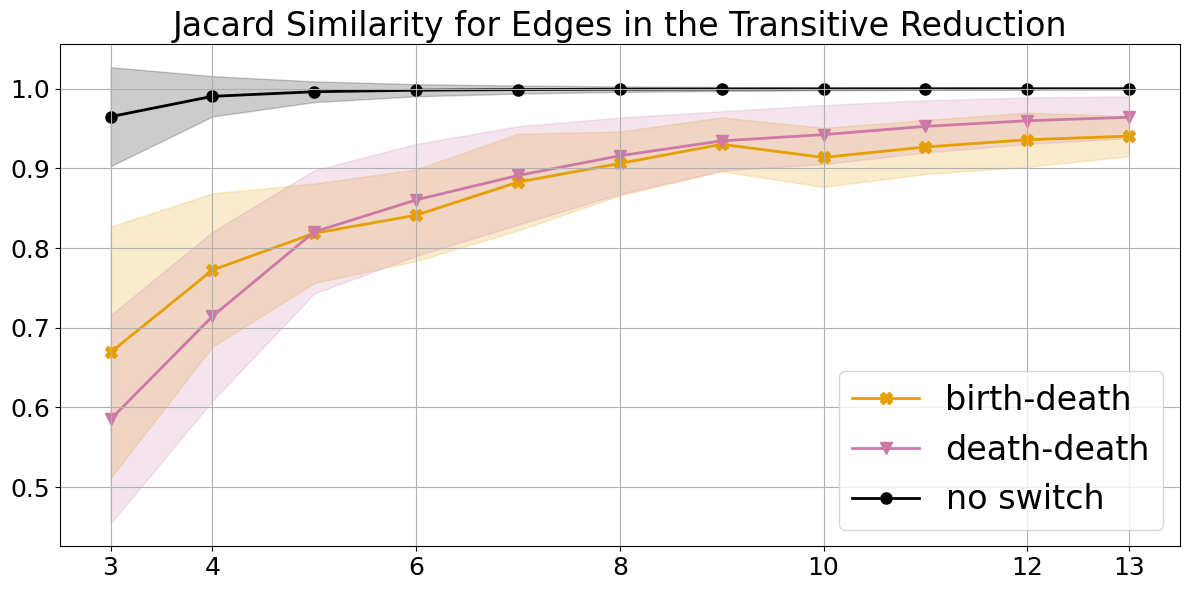

In [23]:
rows = df_scores_mean.columns.to_frame()[['score', 'complex_dim', 'dim']].drop_duplicates().reset_index(drop=True)

for i, (score, complex_dim, dim) in tqdm(rows.iterrows(), total=len(rows)):
    path = os.path.join(path_to_save, picscores_filename_template.format(score=score.replace('_', '-'), complex_dim=complex_dim, dim=dim))

    df_this_mean = df_scores_mean[score][complex_dim][dim]
    df_this_std = df_scores_std[score][complex_dim][dim]

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.set_title(score_titles[score], fontsize=24)

    for col in df_this_mean.columns:
        x = df_this_mean.index.values
        y_mean = df_this_mean[col].values
        y_std = df_this_std[col].values
        ax.plot(x, y_mean, color=switch_type_colors[col], marker=switch_type_markers[col], label=col, linewidth=2, markersize=8, zorder=1)
        ax.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2, color=switch_type_colors[col], zorder=0)

    xticks = ax.get_xticks().astype(int)
    xticks = np.concatenate([xticks[(xticks > x.min())&(xticks < x.max())], [x.min(), x.max()]]).astype(int)
    xticks = np.unique(xticks)
    ax.set_xticks(xticks)
    ax.set_xticklabels(ax.get_xticks(), fontsize=18)
    
    yticks = ax.get_yticks()
    if (yticks.astype(int) == yticks).all():
        yticks = yticks.astype(int)
    y_max = (df_this_mean + df_this_std).max().max()
    y_min = (df_this_mean - df_this_std).min().min()
    while (y_max < 0.5*(yticks[-1] + yticks[-2])) and (len(yticks) > 3):
        yticks = yticks[:-1]
    while (y_min > 0.5*(yticks[0] + yticks[1])) and (len(yticks) > 3):
        yticks = yticks[1:]
    yticks = np.round(yticks, 2)
    yticks = yticks[yticks >= 0]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=18) 

    
    ax.grid(True)
    ax.legend(fontsize=24)
    #plt.xlabel('$n$')
    #plt.ylabel(score)
    plt.tight_layout()
    plt.savefig(path)
    if i < len(rows) - 1:
        plt.close()
plt.show()

In [24]:
figure_1_layer_template = r"""
\begin{{figure}}[htbp]
\centering
{subfigures}
\caption{{{caption}}}
\label{{{label}}}
\end{{figure}}
""".strip()

In [25]:
def latexize(score):
    return score.replace('_', r'\_')

def labelize(label):
    return label.replace('_', '')

In [26]:
score_label_template = 'fig:{score}complex{complex_dim}'

In [27]:
scores_ltx_pics = []

rows = df_scores_mean.columns.to_frame()[['score', 'complex_dim']].drop_duplicates().reset_index(drop=True)

for irow, (score, complex_dim) in rows.iterrows():
    figwidth = round(0.90/(complex_dim + 1), 2)

    subfigures = []
    for dim in range(complex_dim + 1):
        path = os.path.join(path_to_save, picscores_filename_template.format(score=score.replace('_', '-'), complex_dim=complex_dim, dim=dim))
        path = path.replace(r'raports/', '')
        caption = f"Cells dimension {dim}"
        label = f'fig:{labelize(score)}complex{complex_dim}cells{dim}'
        subfigures.append(subfigure_template.format(figwidth=figwidth, path=path, caption=caption, label=label))
    
    subfigures = '\n\\hfill\n'.join(subfigures)
    caption = f'Similarity score {latexize(score)} for $\\mathbb{{T}}_n^{{{complex_dim}}}$'
    label = score_label_template.format(complex_dim=complex_dim, score=score.replace('_', ''))
    scores_ltx_pics.append(figure_1_layer_template.format(subfigures=subfigures, caption=caption, label=label))
scores_ltx_pics = '\n\n'.join(scores_ltx_pics)

In [28]:
score_item_template = """
\\item \\textbf{{{score}}} - {descr}
""".strip()

scores_ltx_descr = [score_item_template.format(score=latexize(score), descr=getattr(depth_poset_similarity_scores, score).__doc__.strip()) for score in scores]
scores_ltx_descr = '\n'.join(scores_ltx_descr)
scores_ltx_descr = f"""
\\begin{{itemize}}
{scores_ltx_descr}
\\end{{itemize}}
""".strip()

print(scores_ltx_descr)

\begin{itemize}
\item \textbf{birth\_relation\_cell\_similarity} - The Jacard index of arcs (edges) in the birth relation (given by row left to right reduction algorithm).
    Consider 2 birth-death pairs are similar if they corespond the similar cells.
\item \textbf{death\_relation\_cell\_similarity} - The Jacard index of arcs (edges) in the death relation (given by column bottom to top reduction algorithm).
    Consider 2 birth-death pairs are similar if they corespond the similar cells.
\item \textbf{poset\_closure\_arcs\_cell\_similarity} - The Jacard index of arcs (edges) in the transitive closure of the Depth Posets.
    Consider 2 birth-death pairs are similar if they corespond the similar cells.
\item \textbf{poset\_reduction\_arcs\_cell\_similarity} - The Jacard index of arcs (edges) in the transitive reduction of the Depth Posets.
    Consider 2 birth-death pairs are similar if they corespond the similar cells.
\end{itemize}


In [29]:
df_scoredim_status = df.groupby('complex_dim')[scores].count() > 0

df_scoredim = pd.DataFrame([[score_label_template.format(complex_dim=dim, score=score.replace('_', '')) for score in df_scoredim_status.columns] for dim in df_scoredim_status.index], 
                           columns=df_scoredim_status.columns, index=df_scoredim_status.index).map(lambda ref: f'Fig. \\ref{{{ref}}}')
df_scoredim.where(df_scoredim_status, '', inplace=True)

df_scoredim.index.name = 'dim'
df_scoredim = df_scoredim.rename(columns=latexize)

df_scoredim

,birth\_relation\_cell\_similarity,death\_relation\_cell\_similarity,poset\_closure\_arcs\_cell\_similarity,poset\_reduction\_arcs\_cell\_similarity
dim,,,,
2,Fig. \ref{fig:birthrelationcellsimilaritycompl...,Fig. \ref{fig:deathrelationcellsimilaritycompl...,Fig. \ref{fig:posetclosurearcscellsimilarityco...,Fig. \ref{fig:posetreductionarcscellsimilarity...


In [30]:
scores_ltx_table = f"""
\\par The distribution of the similarity scores for different models $\\mathbb{{T}}^{{dim}}_n$ we can see in the following figures:
\\begin{{center}}
{df_scoredim.transpose().to_latex()}
\\end{{center}}
""".strip()

print(scores_ltx_table)

\par The distribution of the similarity scores for different models $\mathbb{T}^{dim}_n$ we can see in the following figures:
\begin{center}
\begin{tabular}{ll}
\toprule
dim & 2 \\
\midrule
birth\_relation\_cell\_similarity & Fig. \ref{fig:birthrelationcellsimilaritycomplex2} \\
death\_relation\_cell\_similarity & Fig. \ref{fig:deathrelationcellsimilaritycomplex2} \\
poset\_closure\_arcs\_cell\_similarity & Fig. \ref{fig:posetclosurearcscellsimilaritycomplex2} \\
poset\_reduction\_arcs\_cell\_similarity & Fig. \ref{fig:posetreductionarcscellsimilaritycomplex2} \\
\bottomrule
\end{tabular}

\end{center}


In [31]:
scores_ltx = f"""
{scores_ltx_descr}
{scores_ltx_table}
{scores_ltx_pics}
"""

# Compile report

In [32]:
# load texts, describing the process
with open('texts/extended-barycentric-cubical-torus-transpositions - descr.txt', 'r') as file:
    s_descr = file.read()

# load LaTeX template
with open('texts/template.tex', 'r') as file:
    ltx_latex = file.read()

In [33]:
body = f"""
\\section{{Description}}
{s_descr}
\\newpage

\\section{{Switch Types Distributions}}
{switch_type_distributions_ltx}
\\newpage

\\section{{Similarity Scores}}
{scores_ltx}

"""

raport = ltx_latex.replace('BODY', body)

In [34]:
with open('raports/extended-barycentric-torus-transpositions.tex', 'w') as file:
    file.write(raport)


In [35]:
os.chdir('raports')
result = subprocess.run(
    ['pdflatex', 'extended-barycentric-torus-transpositions.tex'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)
os.chdir('..')

# Copy and Rename Figures to the Overleaf Project Format

In [36]:
output_path = 'pics/overleaf/Lefschetz transpositions/Charts'
if not os.path.exists(output_path):
    os.makedirs(output_path)

## Score Plots

In [37]:
input_path_scores = 'raports/pics/extended torus scores'

if os.path.exists(input_path_scores):
    scores_filenames = os.listdir(input_path_scores)
else:
    scores_filenames = []

score_paths = pd.Series(scores_filenames).apply(lambda filename: os.path.join(input_path_scores, filename))

In [38]:
score_rename_dict = {
    'height': 'height', 
    'number-of-relations': 'Narcs', 
    'number-of-components': 'Ncomponents', 
    'cycles-dimension': 'Ncycles', 
    'number-of-maximal-nodes': 'Nmax', 
    'number-of-minimal-nodes': 'Nmin', 
    'number-of-nodes': 'Nnodes', 
}

In [39]:
object_rename_dict = {
    'full': 'full', 
    'row reduction': 'rows', 
    'column reduction': 'columns'
}

In [40]:
import re

def match_format(string: str, format_string: str) -> dict | None:
    # Экранируем все спецсимволы, кроме фигурных скобок
    pattern = re.escape(format_string)
    # Заменяем экранированные {name} на именованные группы (?P<name>.+?)
    pattern = re.sub(r'\\{(\w+)\\}', r'(?P<\1>.+?)', pattern)
    match = re.fullmatch(pattern, string)
    if match:
        return match.groupdict()
    return None


In [41]:
match_format('raports/pics/extended torus scores/score=number-of-maximal-nodes, dim=2, object=row reduction.png', 
             'raports/pics/extended torus scores/score={score}, dim={dim}, object={object}.png')

{'score': 'number-of-maximal-nodes', 'dim': '2', 'object': 'row reduction'}

In [42]:
score_file_formats = pd.Series({
    '{score},d={dim},{object}.png': 'raports/pics/extended torus scores/score={score}, dim={dim}, object={object}.png', 
    '{score},{object}.png': 'raports/pics/extended torus scores/score={score}, dim=2, object={object}.png', 
    '{score},d={dim}.png': 'raports/pics/extended torus scores/score={score}, dim={dim}, object=full.png', 
})

In [43]:
df_score_paths = pd.concat([
    pd.DataFrame({
        'origin': score_paths,
        'template': key,
        'parameters': score_paths.apply(lambda s: match_format(s, value))
    }) for key, value in score_file_formats.items()
])
df_score_paths = df_score_paths[~df_score_paths['parameters'].isna()]
df_score_paths = df_score_paths.reset_index(drop=True)

df_score_params = df_score_paths['parameters'].apply(pd.Series)
df_score_params['score'] = df_score_params['score'].map(score_rename_dict)
df_score_params['object'] = df_score_params['object'].map(object_rename_dict)
df_score_paths['parameters'] = df_score_params.apply(lambda row: row[~row.isna()].to_dict(), axis=1)

df_score_paths['output'] = df_score_paths.apply(lambda row: row['template'].format(**row['parameters']), axis=1)
#df_score_paths['output'] = df_score_paths['output'].apply(lambda filename: os.path.join(output_path, filename))

df_score_paths = df_score_paths[['origin', 'output']]

print(f'df_score_paths.shape = {df_score_paths.shape}')
df_score_paths.head()

df_score_paths.shape = (49, 2)


,origin,output
0,raports/pics/extended torus scores/score=numbe...,"Nmax,d=2,rows.png"
1,raports/pics/extended torus scores/score=numbe...,"Narcs,d=3,full.png"
2,raports/pics/extended torus scores/score=numbe...,"Narcs,d=2,full.png"
3,raports/pics/extended torus scores/score=cycle...,"Ncycles,d=3,full.png"
4,raports/pics/extended torus scores/score=numbe...,"Nmin,d=2,rows.png"


# Homotopy Plots

In [44]:

input_path_transp = 'raports/pics/torus-transpositions-extended'

if os.path.exists(input_path_transp):
    transp_filenames = os.listdir(input_path_scores)
else:
    transp_filenames = []

input_paths = pd.concat([
    pd.Series(transp_filenames).apply(lambda filename: os.path.join(input_path_transp, filename)),
]).reset_index(drop=True)

input_paths.describe()

count                                                    23
unique                                                   23
top       raports/pics/torus-transpositions-extended/sco...
freq                                                      1
dtype: object

In [45]:
input_path_transp = 'raports/pics/torus-transpositions-extended'

if os.path.exists(input_path_transp):
    transp_filenames = os.listdir(input_path_transp)
else:
    transp_filenames = []

transp_paths = pd.Series(transp_filenames).apply(lambda filename: os.path.join(input_path_transp, filename))

In [46]:
print('\n'.join(transp_paths))

raports/pics/torus-transpositions-extended/score-poset-closure-arcs-cell-similarity-complex-dim2-transpositions-dim0.png
raports/pics/torus-transpositions-extended/score-birth-relation-cell-similarity-complex-dim2-transpositions-dim2.png
raports/pics/torus-transpositions-extended/transposition-types-complex-dim2-subposet-dim0-drop-no-switches-False.png
raports/pics/torus-transpositions-extended/score-birth-relation-cell-similarity-complex-dim2-transpositions-dim1.png
raports/pics/torus-transpositions-extended/score-death-relation-cell-similarity-complex-dim2-transpositions-dim2.png
raports/pics/torus-transpositions-extended/distribution.png
raports/pics/torus-transpositions-extended/score-poset-closure-arcs-cell-similarity-complex-dim2-transpositions-dim1.png
raports/pics/torus-transpositions-extended/transposition-types-complex-dim2-subposet-dim0-drop-no-switches-True.png
raports/pics/torus-transpositions-extended/score-poset-closure-arcs-cell-similarity-complex-dim2-transpositions-di

In [47]:
transp_file_formats = pd.Series({
    'switches,cells-dim{dim}.png': 'raports/pics/torus-transpositions-extended/transposition-types-complex-dim2-subposet-dim{dim}-drop-no-switches-True.png', 
    'transpositions,cells-dim{dim}.png': 'raports/pics/torus-transpositions-extended/transposition-types-complex-dim2-subposet-dim{dim}-drop-no-switches-False.png', 
    'reduced,cell-dim{dim},similarity.png': 'raports/pics/torus-transpositions-extended/score-poset-reduction-arcs-cell-similarity-complex-dim2-transpositions-dim{dim}.png', 
    'poset,cell-dim{dim},similarity.png': 'raports/pics/torus-transpositions-extended/score-poset-closure-arcs-cell-similarity-complex-dim2-transpositions-dim{dim}.png', 
})

In [48]:
df_transp_paths = pd.concat([
    pd.DataFrame({
        'origin': transp_paths,
        'template': key,
        'parameters': transp_paths.apply(lambda s: match_format(s, value))
    }) for key, value in transp_file_formats.items()
])
df_transp_paths = df_transp_paths[~df_transp_paths['parameters'].isna()]
df_transp_paths = df_transp_paths.reset_index(drop=True)

df_transp_paths['output'] = df_transp_paths.apply(lambda row: row['template'].format(**row['parameters']), axis=1)

df_transp_paths = df_transp_paths[['origin', 'output']]

print(f'df_transp_paths.shape = {df_transp_paths.shape}')
df_transp_paths.head()

df_transp_paths.shape = (12, 2)


,origin,output
0,raports/pics/torus-transpositions-extended/tra...,"switches,cells-dim0.png"
1,raports/pics/torus-transpositions-extended/tra...,"switches,cells-dim1.png"
2,raports/pics/torus-transpositions-extended/tra...,"switches,cells-dim2.png"
3,raports/pics/torus-transpositions-extended/tra...,"transpositions,cells-dim0.png"
4,raports/pics/torus-transpositions-extended/tra...,"transpositions,cells-dim1.png"


## Choose the Files to copy

In [49]:
filenames_used_in_document = [
    # scores
    'height,d=1.png', 'height,d=2.png', 'height,d=3.png', 
    'Narcs,d=1.png', 'Narcs,d=2.png', 'Narcs,d=3.png',  
    'Ncycles,d=1.png', 'Ncycles,d=2.png', 'Ncycles,d=3.png', 
    'Nnodes,d=1.png', 'Nnodes,d=2.png', 'Nnodes,d=3.png', 
    'Ncomponents,columns.png', 'Ncomponents,full.png', 'Ncomponents,rows.png', 
    'Nmax,columns.png', 'Nmax,full.png', 'Nmax,rows.png', 
    'Nmin,columns.png', 'Nmin,full.png', 'Nmin,rows.png', 
    # homotopies
    'poset,cell-dim0,similarity.png', 'poset,cell-dim1,similarity.png', 'poset,cell-dim2,similarity.png', 
    'reduced,cell-dim0,similarity.png', 'reduced,cell-dim1,similarity.png', 'reduced,cell-dim2,similarity.png', 
    'switches,cells-dim0.png', 'switches,cells-dim1.png', 'switches,cells-dim2.png', 
    'transpositions,cells-dim0.png', 'transpositions,cells-dim1.png', 'transpositions,cells-dim2.png', 
]

In [50]:
# choosing the plots, which are used in the document
df_paths = pd.concat([df_score_paths, df_transp_paths])
df_paths = df_paths[df_paths['output'].isin(filenames_used_in_document)]
assert len(filenames_used_in_document) == len(df_paths)

# correct output path
df_paths['output'] = df_paths['output'].apply(lambda filename: os.path.join(output_path, filename))


print(f'df_paths.shape = {df_paths.shape}')
df_paths.head()

df_paths.shape = (33, 2)


,origin,output
21,raports/pics/extended torus scores/score=numbe...,pics/overleaf/Lefschetz transpositions/Charts/...
23,raports/pics/extended torus scores/score=numbe...,pics/overleaf/Lefschetz transpositions/Charts/...
24,raports/pics/extended torus scores/score=numbe...,pics/overleaf/Lefschetz transpositions/Charts/...
25,raports/pics/extended torus scores/score=numbe...,pics/overleaf/Lefschetz transpositions/Charts/...
26,raports/pics/extended torus scores/score=numbe...,pics/overleaf/Lefschetz transpositions/Charts/...


## Finally copy and rename the Plots

In [51]:
import shutil

In [52]:
for _, row in tqdm(df_paths.iterrows(), total=len(df_paths)):
    origin = row['origin']
    output = row['output']
    
    os.makedirs(os.path.dirname(output), exist_ok=True)
    
    shutil.copy2(origin, output)


100%|██████████| 33/33 [00:00<00:00, 1460.54it/s]
